In [1]:
%matplotlib inline

In [2]:
import requests
import re
from fastai.text import *
import torch

In [3]:
book = requests.get('https://www.gutenberg.org/files/36/36-0.txt').text

In [4]:
start_iter = re.finditer('BOOK ONE', book)

In [5]:
next(start_iter)

<_sre.SRE_Match object; span=(1067, 1075), match='BOOK ONE'>

Commenting out some print lines here to shrink the notebook -- I did some exploration to figure out where the actual story began and ended (excluding table of contents, acknowledgements, etc.)

In [6]:
# book[1067:]

In [7]:
next(start_iter)

<_sre.SRE_Match object; span=(1920, 1928), match='BOOK ONE'>

In [8]:
# book[1920:]

In [9]:
book = book[1920:]

In [10]:
end_iter = re.finditer("among the dead.", book)

In [11]:
next(end_iter)

<_sre.SRE_Match object; span=(64109, 64124), match='among the dead '>

In [12]:
# book[:64125]

In [13]:
next(end_iter)

<_sre.SRE_Match object; span=(345594, 345609), match='among the dead.'>

In [14]:
# book[:345609]

In [15]:
book = book[:345609]

In [16]:
book = re.sub(r'[\r\n]+', ' ', str(book))

In [17]:
# book

In [18]:
tokens = [i.replace(',', '') for i in book.split('.')]

In [19]:
# tokens

In [20]:
tokens[:10]

['BOOK ONE THE COMING OF THE MARTIANS I',
 ' THE EVE OF THE WAR',
 ' No one would have believed in the last years of the nineteenth century that this world was being watched keenly and closely by intelligences greater than manâ\x80\x99s and yet as mortal as his own; that as men busied themselves about their various concerns they were scrutinised and studied perhaps almost as narrowly as a man with a microscope might scrutinise the transient creatures that swarm and multiply in a drop of water',
 ' With infinite complacency men went to and fro over this globe about their little affairs serene in their assurance of their empire over matter',
 ' It is possible that the infusoria under the microscope do the same',
 ' No one gave a thought to the older worlds of space as sources of human danger or thought of them only to dismiss the idea of life upon them as impossible or improbable',
 ' It is curious to recall some of the mental habits of those departed days',
 ' At most terrestrial men fa

In [21]:
! rm book_text.csv

In [22]:
with open('book_text.csv', 'a+') as file:
    for sentence in tokens:
        file.write(sentence + '\n')

In [23]:
with open('book_text.csv') as file:
    lines = file.readlines()[:5]
print(lines[0])
print(lines[1])
print(lines[2])

BOOK ONE THE COMING OF THE MARTIANS I

 THE EVE OF THE WAR

 No one would have believed in the last years of the nineteenth century that this world was being watched keenly and closely by intelligences greater than manâs and yet as mortal as his own; that as men busied themselves about their various concerns they were scrutinised and studied perhaps almost as narrowly as a man with a microscope might scrutinise the transient creatures that swarm and multiply in a drop of water



In [24]:
pd.read_csv('book_text.csv').iloc[20][0]

' And looking across space with instruments and intelligences such as we have scarcely dreamed of they see at its nearest distance only 35000000 of miles sunward of them a morning star of hope our own warmer planet green with vegetation and grey with water with a cloudy atmosphere eloquent of fertility with glimpses through its drifting cloud wisps of broad stretches of populous country and narrow navy-crowded seas'

In [94]:
data = TextLMDataBunch.from_csv('.', 'book_text.csv', text_cols=0)

In [95]:
data

TextLMDataBunch;

Train: LabelList (2434 items)
x: LMTextList
xxbos xxmaj for my own part i had been xxunk excited all day,xxbos xxmaj and through the charred and xxunk xxunk twenty square miles xxunk xxunk the xxmaj martian encampment on xxmaj horsell xxmaj common through charred and ruined villages among the green trees through the blackened and smoking xxunk that had been but a day ago pine xxunk crawled the xxunk scouts with the xxunk that were presently to warn the gunners of the xxmaj martian approach,xxbos xxmaj byfleet was in a tumult ; people packing and a score of hussars some of them dismounted some on xxunk were hunting them about,xxbos âulla ulla ulla ullaâ xxunk that xxunk xxunk waves of sound sweeping down the broad sunlit roadway between the tall buildings on each side,xxbos xxmaj there were half a dozen xxunk or more from the xxmaj woking station standing in the road by the sand - pits a basket - chaise from xxmaj chobham and a rather xxunk carriage
y: LMLabelList


In [96]:
data.train_ds[0]

(Text xxbos xxmaj for my own part i had been xxunk excited all day,
 EmptyLabel )

In [97]:
data.train_ds[1][0].data

array([  2,   5,  10,  65, ...,   9,   5,  98, 561])

In [98]:
data.valid_ds[1][0].data

array([   2,    5,   74, 2367,   27,    9,  194,  201,    0, 1310, 1630,   10,   93,  137,  607,   14, 2915,   15,
        264,   22,   73, 1872,   25])

In [99]:
data.one_batch()[0].shape

torch.Size([64, 70])

In [100]:
x, y = data.one_batch()

In [101]:
x.shape, y.shape

(torch.Size([64, 70]), torch.Size([64, 70]))

In [102]:
x[0], y[0]

(tensor([  28,    9,    5,  158,  203,  213,   15,    9,   80,   33,    9,  309,
           29,  517,   12, 1232,   29,  696,   28,    5,  563,   10,   12,  781,
            0, 1233,    2,    5,   48,  214,   13,   68,   50,   42, 1234,   27,
            9,  782,   11,    9,  518,   15,  878,    0,   10,  783,   71,  879,
            2,    5, 2058,    5,   18,  197, 2059,  134,   62,  191,   12,  564,
            2,    5,   36,    0,   45,   10,   31, 1235,  215,   36]),
 tensor([   9,    5,  158,  203,  213,   15,    9,   80,   33,    9,  309,   29,
          517,   12, 1232,   29,  696,   28,    5,  563,   10,   12,  781,    0,
         1233,    2,    5,   48,  214,   13,   68,   50,   42, 1234,   27,    9,
          782,   11,    9,  518,   15,  878,    0,   10,  783,   71,  879,    2,
            5, 2058,    5,   18,  197, 2059,  134,   62,  191,   12,  564,    2,
            5,   36,    0,   45,   10,   31, 1235,  215,   36,  405]))

In [103]:
len(data.vocab.itos)

3120

In [104]:
nv = len(data.vocab.itos)

In [105]:
nh = 64

In [106]:
bs = 64

In [107]:
nv, nh, bs

(3120, 64, 64)

In [108]:
class BasicLanguageModel(nn.Module):
     
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.h_h = nn.Linear(nh, nh)
        self.h_o = nn.Linear(nh, nv)
        self.bn = nn.BatchNorm1d(nh)
        self.reset()
        
    def forward(self, x):
        print("input size: ", x.size())
        res = []
        h = self.h
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i]) 
            h = F.relu(self.h_h(h))
            res.append(self.bn(h))
        print("hidden layer size: ", h.size())
        print("res size: ", res[0].size())
        self.h = h.detach()
        res = torch.stack(res, dim=1)
        print("stacked res size: ", res.size())
        print("output size: ", self.h_o(res).size())
        return self.h_o(res)
    
    def reset(self):
        self.h = torch.zeros(nh, nh).cuda()

In [109]:
mdl = BasicLanguageModel()

In [110]:
mdl.batch_first = True

In [111]:
data.label_list

LabelLists;

Train: LabelList (2434 items)
x: LMTextList
xxbos xxmaj for my own part i had been xxunk excited all day,xxbos xxmaj and through the charred and xxunk xxunk twenty square miles xxunk xxunk the xxmaj martian encampment on xxmaj horsell xxmaj common through charred and ruined villages among the green trees through the blackened and smoking xxunk that had been but a day ago pine xxunk crawled the xxunk scouts with the xxunk that were presently to warn the gunners of the xxmaj martian approach,xxbos xxmaj byfleet was in a tumult ; people packing and a score of hussars some of them dismounted some on xxunk were hunting them about,xxbos âulla ulla ulla ullaâ xxunk that xxunk xxunk waves of sound sweeping down the broad sunlit roadway between the tall buildings on each side,xxbos xxmaj there were half a dozen xxunk or more from the xxmaj woking station standing in the road by the sand - pits a basket - chaise from xxmaj chobham and a rather xxunk carriage
y: LMLabelList
,,,,


In [112]:
data

TextLMDataBunch;

Train: LabelList (2434 items)
x: LMTextList
xxbos xxmaj for my own part i had been xxunk excited all day,xxbos xxmaj and through the charred and xxunk xxunk twenty square miles xxunk xxunk the xxmaj martian encampment on xxmaj horsell xxmaj common through charred and ruined villages among the green trees through the blackened and smoking xxunk that had been but a day ago pine xxunk crawled the xxunk scouts with the xxunk that were presently to warn the gunners of the xxmaj martian approach,xxbos xxmaj byfleet was in a tumult ; people packing and a score of hussars some of them dismounted some on xxunk were hunting them about,xxbos âulla ulla ulla ullaâ xxunk that xxunk xxunk waves of sound sweeping down the broad sunlit roadway between the tall buildings on each side,xxbos xxmaj there were half a dozen xxunk or more from the xxmaj woking station standing in the road by the sand - pits a basket - chaise from xxmaj chobham and a rather xxunk carriage
y: LMLabelList


In [113]:
type(data)

fastai.text.data.TextLMDataBunch

In [126]:
learn = LanguageLearner(data, model=, metrics=accuracy)

NameError: name 'arch' is not defined

In [121]:
learn.summary()

input size:  torch.Size([1, 70])
hidden layer size:  torch.Size([64, 64])
res size:  torch.Size([64, 64])
stacked res size:  torch.Size([64, 70, 64])
output size:  torch.Size([64, 70, 3120])


BasicLanguageModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [64]                 199,680    True      
______________________________________________________________________
Linear               [64]                 4,160      True      
______________________________________________________________________
Linear               [70, 3120]           202,800    True      
______________________________________________________________________
BatchNorm1d          [64]                 128        True      
______________________________________________________________________

Total params: 406,768
Total trainable params: 406,768
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : FlattenedLoss
Callbacks functions applied 
    RNNTrainer

In [122]:
data.show_batch()

idx,text
0,sailors could no longer come up the xxmaj thames they came on to the xxmaj essex coast to xxmaj harwich and xxmaj walton and xxmaj xxunk and afterwards to xxmaj foulness and xxmaj xxunk to bring off the people xxbos â i resolved to leave xxunk that i had ! xxmaj xxunk now for the xxunk xxunk i xxunk out food and drink xxbos xxmaj haggard special xxunk with white
1,way!â xxmaj it was like riding into the smoke of a fire to approach the meeting point of the lane and road ; the crowd xxunk like a fire and the dust was hot and pungent xxbos âulla ulla ulla ullaâ cried the voice coming as it seemed to me from the district about xxmaj regentâs xxmaj park xxbos xxmaj its physical condition is still xxunk a xxunk but we
2,two days of xxunk and rain and at xxmaj clapham xxmaj junction the line had been wrecked again ; there were hundreds of out - of - work clerks and shopmen working side by side with the xxunk navvies and we were jolted over a hasty xxunk xxbos â âwhat xxunk xxunk xxunk âno xxunk and the artilleryman began a vivid account of the xxmaj heat - xxmaj ray xxbos
3,curate and stopped at the scullery door xxbos i whispered for the curate several times and at last felt my way to the door of the kitchen xxbos xxmaj we got to xxmaj hampton xxmaj court without misadventure our minds full of strange and unfamiliar appearances and at xxmaj hampton xxmaj court our eyes were relieved to find a patch of green that had escaped the xxunk xxunk xxbos i
4,road xxbos xxmaj iâve been in sight of death once or twice ; xxmaj iâm not an xxunk soldier and at the best and worst xxunk just death xxbos xxmaj that xxunk up xxbos xxmaj the vapour did not xxunk as a true gas would do xxbos xxmaj close on the rear of this came a couple of cabs the xxunk of a long xxunk of flying vehicles going for


In [123]:
learn.data.bs

64

In [124]:
learn.fit_one_cycle(10, max_lr=3e-2)

epoch,train_loss,valid_loss,accuracy,time


input size:  torch.Size([64, 70])
hidden layer size:  torch.Size([64, 64])
res size:  torch.Size([64, 64])
stacked res size:  torch.Size([64, 70, 64])
output size:  torch.Size([64, 70, 3120])


ValueError: Expected input batch_size (70) to match target batch_size (4480).

In [144]:
learn.export(file="export.pkl")

/home/paperspace/anaconda3/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type BasicLanguageModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [145]:
pred_mdl = load_learner(".", "export.pkl")

In [146]:
pred_mdl.predict("The ")

TypeError: only integer tensors of a single element can be converted to an index

In [55]:
learn.fit_one_cycle(20, max_lr=3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.879877,6.727090,0.085993,00:00
1,6.634016,5.958604,0.175949,00:00
2,6.021026,4.314600,0.229241,00:00
3,5.372983,3.986629,0.256306,00:00
4,4.911340,3.886966,0.264955,00:00
5,4.575227,3.848140,0.276897,00:00
6,4.319477,3.857784,0.276116,00:01
7,4.118579,3.862509,0.277790,00:00
8,3.954926,3.927150,0.266853,00:00
9,3.819950,3.912256,0.280134,00:00


In [56]:
learn.save("basic")

In [57]:
pred_mdl = LanguageLearner(data, BasicLanguageModel(), metrics=accuracy)

In [58]:
pred_mdl.load("basic")

/home/paperspace/anaconda3/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type BasicLanguageModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


LanguageLearner(data=TextLMDataBunch;

Train: LabelList (2434 items)
x: LMTextList
xxbos xxmaj to get under water ! xxmaj that was it ! xxunk under xxunk i shouted xxunk,xxbos i turned and running xxunk made for the first group of trees perhaps a hundred yards away ; but i ran xxunk and xxunk for i could not xxunk my face from these things,xxbos xxmaj it was with the greatest xxunk they could get her down to the xxunk where presently my brother succeeded in xxunk the attention of some men on a xxunk steamer from the xxmaj thames,xxbos xxmaj he looked back saw what i was doing and turned to xxunk me,xxbos xxmaj among these were a couple of xxunk a xxunk xxunk i xxunk xxunk a xxunk carrying a xxunk xxmaj xxunk the xxunk and his little boy and two or three xxunk and xxunk xxunk who were xxunk to xxunk about the railway station
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (609 items)
x: LMTextList
xxbos xxmaj now no xxunk human being saw so much of the xxmaj martians in action as i did,x

In [59]:
pred_mdl.predict("The martian ")

IndexError: invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number

# LSTM

In [83]:
class LSTMCustom(nn.Module):
     
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.h_o = nn.Linear(nh, nv)
        self.bn = nn.BatchNorm1d(nh)
        self.h = torch.zeros(bs, nh).cuda()
        self.cell_state = torch.zeros(bs, nh).cuda()
        self.forget_gate = nn.Linear(nh*2, nh)
        self.input_gate = nn.Linear(nh*2, nh)
        self.candidate_gate = nn.Linear(nh*2, nh)
        self.output_gate = nn.Linear(nh*2, nh)
        self.combine_gate = nn.Linear(nh*2, nh)
        
    def forward(self, x):
        res = []
        h = self.h
        cell_state = self.cell_state
        for i in range(x.shape[1]):
            x_i = self.i_h(x[:,i])
            concat = torch.cat([x_i, h], 1)
            forget_gate = nn.Sigmoid()(self.forget_gate(concat))
            cell_state = forget_gate * cell_state
            input_gate = nn.Sigmoid()(self.input_gate(concat))
            candidate_gate = nn.Tanh()(self.candidate_gate(concat))
            cell_state = cell_state + (input_gate * candidate_gate)
            output_gate = nn.Sigmoid()(self.output_gate(concat))
            combine_gate = nn.Tanh()(cell_state)
            h = combine_gate * output_gate 
            res.append(h)
        self.h = h.detach()
        self.cell_state = cell_state.detach()
        res = torch.stack(res, dim=1)
        res = self.h_o(res)
        return res

In [84]:
learn = Learner(data, LSTMCustom(), metrics=accuracy)

In [85]:
learn.bptt = 70

In [86]:
learn.fit_one_cycle(20, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.864742,6.792367,0.159208,00:01
1,6.635358,5.472675,0.191797,00:01
2,5.937733,4.743526,0.221205,00:01
3,5.513904,4.531507,0.221205,00:01
4,5.205496,4.341786,0.235435,00:01
5,4.955205,4.181851,0.248047,00:01
6,4.741245,4.059894,0.255078,00:01
7,4.562502,3.984762,0.255246,00:01
8,4.410934,3.929970,0.263114,00:01
9,4.282375,3.887057,0.265848,00:01


In [87]:
learn.fit_one_cycle(20, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.656716,3.791082,0.285658,00:01
1,3.654055,3.788638,0.286272,00:01
2,3.651327,3.783318,0.285435,00:01
3,3.645024,3.777210,0.286272,00:01
4,3.636613,3.772876,0.284040,00:01
5,3.623350,3.766766,0.286440,00:01
6,3.605362,3.756979,0.289732,00:01
7,3.584810,3.751713,0.292969,00:01
8,3.562498,3.750383,0.287891,00:01
9,3.539610,3.745222,0.290569,00:01


In [88]:
learn.fit_one_cycle(20, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.336965,3.736379,0.294754,00:01
1,3.337911,3.735885,0.293973,00:01
2,3.335223,3.737562,0.295480,00:01
3,3.334676,3.745260,0.295926,00:01
4,3.333137,3.748382,0.296094,00:01
5,3.328768,3.753780,0.291908,00:01
6,3.321503,3.758725,0.294587,00:01
7,3.309969,3.761811,0.293806,00:01
8,3.294904,3.767322,0.292578,00:01
9,3.279323,3.770055,0.294141,00:01


In [89]:
learn.fit_one_cycle(20, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.114398,3.778969,0.294141,00:01
1,3.115606,3.779258,0.294364,00:01
2,3.115293,3.779570,0.294085,00:01
3,3.114501,3.780993,0.293304,00:01
4,3.115257,3.780989,0.293973,00:01
5,3.113943,3.781930,0.294587,00:01
6,3.113512,3.782819,0.294085,00:01
7,3.113523,3.784273,0.293694,00:01
8,3.111033,3.784204,0.292690,00:01
9,3.110197,3.786014,0.294141,00:01


In [395]:
bs = 64

In [396]:
print(bs, nv, nh)

64 1006 64


In [465]:
class LSTMModel(nn.Module):
     
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.h_o = nn.Linear(nh, nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(1, bs, nh).cuda()
        self.c = torch.zeros(1, bs, nh).cuda()
        self.lstm = nn.LSTM(nh, nh, 1, batch_first=True, dropout=0.5) 
        
    def forward(self, x):
        res, (h, c) = self.lstm(self.i_h(x), (self.h, self.c))
        self.h, self.c = h.detach(), c.detach()
        return self.h_o(self.bn(res))

In [466]:
learn = Learner(data, LSTMModel(), metrics=accuracy)

/home/paperspace/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [467]:
learn.fit_one_cycle(20, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.951297,6.906593,0.004632,00:00
1,6.911371,6.844083,0.048884,00:00
2,6.827812,6.621582,0.110993,00:00
3,6.675880,6.158518,0.167969,00:00
4,6.434752,5.493100,0.195033,00:00
5,6.070967,4.755964,0.215123,00:00
6,5.640584,4.252319,0.245592,00:00
7,5.245998,4.046191,0.266071,00:00
8,4.915372,3.936378,0.271540,00:00
9,4.647189,3.870053,0.276507,00:00


In [468]:
learn.fit_one_cycle(20, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.530246,3.771509,0.287277,00:00
1,3.527559,3.770522,0.286328,00:00
2,3.522986,3.766570,0.286607,00:00
3,3.513874,3.760659,0.288504,00:00
4,3.498860,3.758373,0.286607,00:00
5,3.479750,3.761188,0.287891,00:00
6,3.454956,3.765979,0.284933,00:00
7,3.424772,3.756758,0.289788,00:00
8,3.393285,3.761786,0.289788,00:00
9,3.358889,3.772546,0.286886,00:00


In [469]:
learn.fit_one_cycle(20, max_lr=3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,3.077008,3.799859,0.290904,00:00
1,3.076132,3.803214,0.289788,00:00
2,3.075212,3.801907,0.290290,00:00
3,3.074474,3.802700,0.290904,00:00
4,3.073398,3.804970,0.291629,00:00
5,3.072807,3.806811,0.291518,00:00
6,3.070864,3.807528,0.290737,00:00
7,3.069525,3.806668,0.290569,00:00
8,3.067733,3.811751,0.289621,00:00
9,3.064878,3.811629,0.290290,00:00


In [470]:
learn.fit_one_cycle(20, max_lr=3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,3.038305,3.818230,0.289565,00:00
1,3.039619,3.818743,0.289118,00:00
2,3.038204,3.819620,0.289286,00:00
3,3.037751,3.818827,0.290625,00:00
4,3.036355,3.822935,0.290513,00:00
5,3.036094,3.824201,0.289230,00:00
6,3.034132,3.825573,0.289900,00:00
7,3.031486,3.826695,0.291295,00:00
8,3.028876,3.830092,0.289342,00:00
9,3.026451,3.830688,0.289342,00:00


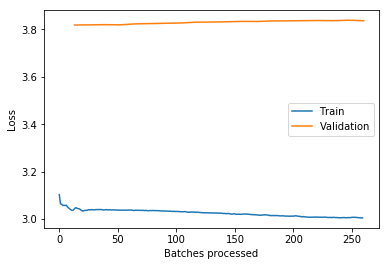

In [471]:
learn.recorder.plot_losses()

Looks like LSTM's give us a boost from ~27-28% to >29% accuracy. Would be interested in tweaking this further and playing around with different LSTM architectures. 

In [475]:
learn.save("lstm")

The code below is an attempt to get this model working with fastai's `predict` method. No such luck -- will need to investigate this further. 

In [486]:
# class LSTMModelPred(nn.Module):
     
#     def __init__(self):
#         super().__init__()
#         self.i_h = nn.Embedding(nv, nh)
#         self.h_o = nn.Linear(nh, nv)
#         self.bn = BatchNorm1dFlat(nh)
#         self.h = torch.zeros(1, 1, nh).cuda()
#         self.c = torch.zeros(1, 1, nh).cuda()
#         self.lstm = nn.LSTM(nh, nh, 1, batch_first=True, dropout=0.5) 
        
#     def forward(self, x):
#         res, (h, c) = self.lstm(self.i_h(x), (self.h, self.c))
#         self.h, self.c = h.detach(), c.detach()
#         return self.h_o(self.bn(res))

In [487]:
# learn2 = Learner(data, LSTMModelPred(), metrics=accuracy)

In [488]:
# learn2.load("lstm")

In [489]:
# learn2.predict("the ")

In [490]:
# learn.predict("the")